In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [4]:
case = "1" # Case 1 is for anomalous density diffusion only.
filepath = "sq3_33/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("sq_midres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 666MB
Dimensions:             (x: 260, y: 1, z: 260, t: 201)
Coordinates:
    dx                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dy                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dz                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 2kB 0.001923 0.005769 ... 0.9942 0.9981
Data variables: (12/52)
    Bxy                 (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G1                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G2                  (x, y, z) float64 541kB dask.array

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [5]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [6]:
dens = ds["Nh+"]
src = ds["SNh+"]
dens_true = dens.copy()

mask = dsn["in_mask"]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [7]:
M0 = dens.where(mask)[0,:,:].sum().values
M1 = dens.where(mask)[10,:,:].sum().values
M2 = dens.where(mask)[100,:,:].sum().values
M3 = dens.where(mask)[-1,:,:].sum().values
print(M0)
print(M1)
print(M2)
print(M3)
print("ΔM =", M3 - M0)
print("relative change =", (M3 - M0)/M0)
assert np.isclose(M3, M0, rtol=1e-10, atol=1e-14)

16768.0
16768.0
16768.0
16767.999999999996
ΔM = -3.637978807091713e-12
relative change = -2.1695961397254967e-16


In [8]:
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 256
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

m = 3.0
n = 3.0
# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

ghosts_lo_x = x[0]  - dx*np.arange(2, 0, -1)
ghosts_hi_x = x[-1] + dx*np.arange(1, 2+1)
x = np.concatenate((ghosts_lo_x, x, ghosts_hi_x))
xx,zz = np.meshgrid(x,z,indexing='ij')

#Use physical grid values to map R,Z boundary to x,z (i.e. ignore ghosts)
R_min, R_max = dsn["R"].values[2,0], dsn["R"].values[-3,0]
Z_min, Z_max = dsn["Z"].values[0,0], dsn["Z"].values[0,-1]
Lb, Rb = 1.75, 3.25
Bb, Tb = -0.7557692307692307, 0.7557692307692307
xL = x[2] + (Lb - R_min) * (x[-3] - x[2]) / (R_max - R_min)
xR = x[2] + (Rb - R_min) * (x[-3] - x[2]) / (R_max - R_min)
zB = z[0] + (Bb - Z_min) * (z[-1] - z[0]) / (Z_max - Z_min)
zT = z[0] + (Tb - Z_min) * (z[-1] - z[0]) / (Z_max - Z_min)

Lx = xR - xL
Lz = zT - zB
xi   = (x - xL)/ Lx
zeta = (z - zB)/ Lz
lbda = (m*np.pi/(Rb-Lb))**2 + (n*np.pi/(Tb-Bb))**2

xxi, zzeta = np.meshgrid(xi,zeta,indexing='ij',copy=False)
D      = 0.2
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = np.cos(m*np.pi*xx)*np.cos(n*np.pi*zz)
#temp = np.exp(-lbda*D*(t_norm))

print(xL)
print(zB)
print(Lx)
print(Lz)

n0 = dens.values[0, 120,120]      # at t = 0
n1 = dens.values[1, 120,120]      # at t_index k (known step, but we ignore it for this calc)

ratio = (n1 - 1.0) / (n0 - 1.0)
t_eff = -np.log(ratio) / (0.2 * lbda)
print("Effective time from simulation at that point:", t_eff)
#t_norm = np.arange(201)*t_eff
# pick a grid point where the cosine mode is not zero
# the actual simulation timestep in physical units:
dt = t_norm[1] - t_norm[0]      # or however you compute Δt
ratio = (n1 - 1.0) / (n0 - 1.0)
lambda_eff = -np.log(ratio) / (D * dt)
print("Effective lambda from simulation at that point:", lambda_eff)
print("Analytic lambda:", lbda)
print("Percent error:", 100 * (lambda_eff - lbda)/lbda)

print("Simulation timestep output: ", t_norm[1])
spatial = np.cos(m * np.pi * xxi) * np.cos(n * np.pi * zzeta)
temp = np.exp(-D * lbda * t_norm)

#dens_true[:,:,:] = 1 + np.asarray(np.cos(np.pi*xxi)*np.cos(np.pi*zzeta))[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = 1.0 + np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]


0.25
0.24807692307692308
0.5
0.5038461538461538
Effective time from simulation at that point: 0.0052175376008504245
Effective lambda from simulation at that point: 78.32181415071481
Analytic lambda: 78.3564117488502
Percent error: -0.0441541379488952
Simulation timestep output:  0.005219842377254392


In [9]:
M0 = dens_true.where(mask)[0,:,:].sum().values
M1 = dens_true.where(mask)[10,:,:].sum().values
M2 = dens_true.where(mask)[100,:,:].sum().values
M3 = dens_true.where(mask)[-1,:,:].sum().values
print(M0)
print(M1)
print(M2)
print(M3)
print("ΔM =", M3 - M0)
print("relative change =", (M3 - M0)/M0)
assert np.isclose(M3, M0, rtol=1e-10, atol=1e-14)

16768.0
16768.0
16768.0
16768.0
ΔM = 0.0
relative change = 0.0


In [10]:
print(dens.values[0,30,30])
print(dens_true.values[0,30,30])

print(dens.values[10,30,30])
print(dens_true.values[10,30,30])

0.0
1.682799454291752
0.0
1.3013236555125014


0
8.12162266847984e-05


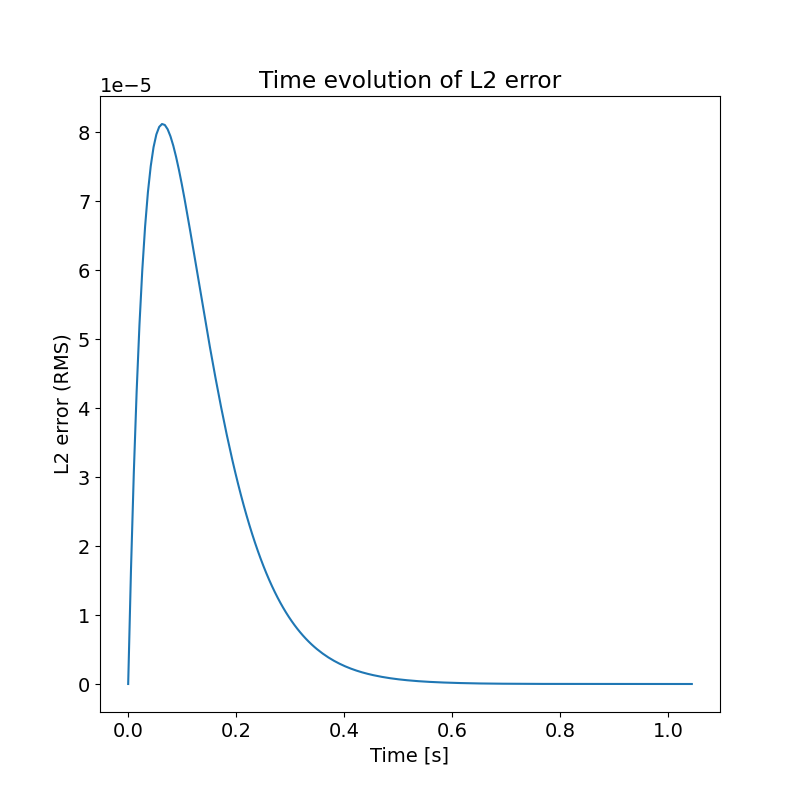

In [12]:
# Number of valid cells
N_valid = np.sum(mask)
#l2 err
dens_diff = np.abs(dens.where(mask)-dens_true.where(mask))
l2_err_t = np.sqrt(np.sum((dens_diff**2)*mask, axis=(1, 2)) / N_valid)

init_dens_diff = dens_diff[0,:,:]
mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
nerrs = int(mask2.sum().compute())

ii, jj = np.where(mask2)

if nerrs > 0:
    print(init_dens_diff.values[ii[0],jj[0]])
    print(dens.values[0,ii[0],jj[0]])
    print(dens_true.values[0,ii[0],jj[0]])

print(nerrs)

plt.close('all')      # optional, but guarantees a clean slate for the whole kernel
print(np.max(l2_err_t.values))
fig, ax = plt.subplots()  # new figure/axes each run
ax.plot(t_norm, l2_err_t)
ax.set_xlabel("Time [s]")
ax.set_ylabel("L2 error (RMS)")
ax.set_title("Time evolution of L2 error")
plt.show()


In [ ]:
dens_diff.where(mask).bout.animate2D(aspect='equal')

In [ ]:

fig, ax = plt.subplots()
plt.contourf(x,z,dens.values[0,:,:])
plt.show()

In [ ]:
print(np.nanmax(init_dens_diff.values))

In [ ]:
src.where(mask).bout.animate2D(aspect='equal')

In [ ]:
no_mask = ~(mask.astype(bool))
src.where(no_mask).bout.animate2D(aspect='equal')
#src.bout.animate2D(aspect='equal')